In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor)
import sys
import os, random

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *

/Users/lucile/causal_info_gain/pjake/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor)
import sys
import os, random
from multiprocessing import Pool
import itertools

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *

print('import done')


rng = np.random.RandomState(42)

varying_sample_sizes = [100, 120, 140, 160, 180, 200]
fixed_n_complementary = 100
n_host = 100 
 # set to None if both candidates have the same sample size


n_rct_before_split = 10**5
std_true_y = 1
sigma_prior = 1
sigma_rand_error = 1
include_intercept = 1  # 0 if no intercept
power_x, power_x_t = 1, 1

np.random.seed(42)
random.seed(42)

X0 = np.random.beta(12, 3, size=n_rct_before_split)
X1 = np.random.normal(loc=4, scale=1, size=n_rct_before_split)
X2 = np.random.beta(1, 7, size=n_rct_before_split)
x_distributions = {"X_0": X0, "X_1": X1, "X_2": X2}
d = (
    include_intercept
    + len(x_distributions) * (power_x)
    + 1
    + len(x_distributions) * (power_x_t)
)


causal_param_first_index = power_x*len(x_distributions) + include_intercept 

p_assigned_to_host = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)
p_assigned_to_cand2 = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)

outcome_function = (
    # y = 1 + 1*X_0 - 1*X_1 + 1*X_2 + 4*T + 2*X_0*T + 2*X_1*T + 0*X_2*T + eps
    lambda X, T, eps: include_intercept  # intercept, non-causal => 0 no intercept
    + 1 * X["X_0"]  # non-causal
    - 1 * X["X_1"]  # non-causal
    + 1 * X["X_2"]  # non-causal
    + 5 * T  # causal
    + 2 * X["X_0"] * T  # causal
    + 2 * X["X_1"] * T  # causal
    - 4 * X["X_2"] * T  # causal
    + eps
)

CATE_function = lambda X: outcome_function(X,np.ones(len(X)), 0 )-outcome_function(X,np.zeros(len(X)),0)

# Prior parameters for Bayesian update on host
if include_intercept:
    prior_mean = np.array([0, 0, 0, 0, 0, 0, 0, 0])
else:
    prior_mean = np.array([0, 0, 0, 0, 0, 0, 0])
assert len(prior_mean) == d, "Shape error"

beta_0, sigma_0_sq, inv_cov_0 = (
    prior_mean,
    sigma_rand_error**2,
    1 / sigma_prior * np.eye(len(prior_mean)),
)
prior_hyperparameters = {
    "beta_0": beta_0,
    "sigma_0_sq": sigma_0_sq,
    "inv_cov_0": inv_cov_0,
}

n_seeds = 50
data_parameters = {
    "fixed_n_complementary": fixed_n_complementary,
    "varying_sample_sizes": varying_sample_sizes,
    "n_rct_before_split": n_rct_before_split,
    "x_distributions": x_distributions,
    "p_assigned_to_cand2": p_assigned_to_cand2,
    "p_assigned_to_host": p_assigned_to_host,
    "n_host": n_host,
    "power_x": power_x,
    "power_x_t": power_x_t,
    "outcome_function": outcome_function,
    "std_true_y": std_true_y,
    "causal_param_first_index": causal_param_first_index,
}

print('hyperparameters done')

def turn_into_diff(arr):
    n, d = np.shape(arr)[0], np.shape(arr)[1]
    result = np.zeros((n//2, d))
    for i in range (n//2):
        result[i,:]=arr[2*i,:]-arr[(2*i) +1,:]
    return result

proportions = np.array(varying_sample_sizes)/fixed_n_complementary
proportions

EIG_obs_closed_form_across_seeds, EIG_caus_closed_form_across_seeds = [], []
store_non_exact_data = {}

for i in range(n_seeds):
    nonexact_data = generate_data_varying_sample_size(
        data_parameters, include_intercept=bool(include_intercept), seed=i)
    
    EIGs = linear_eig_closed_form_varying_sample_size(  
        nonexact_data,
        data_parameters,
        prior_hyperparameters,
        verbose=False,
    )
    EIG_obs_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )
    store_non_exact_data[i] = nonexact_data


print('computed closed form')

EIG_obs_closed_form_across_seeds = np.vstack(EIG_obs_closed_form_across_seeds)  
EIG_caus_closed_form_across_seeds = np.vstack(EIG_caus_closed_form_across_seeds)

predictive_closed_form = pd.DataFrame(turn_into_diff(EIG_obs_closed_form_across_seeds))
caus_closed_form = pd.DataFrame(turn_into_diff(EIG_caus_closed_form_across_seeds))

predictive_closed_form.to_csv("/home/ma/l/ltt19/code_causal_eig/data_results/predictive_closed_form.csv",mode='w+')
caus_closed_form.to_csv("/home/ma/l/ltt19/code_causal_eig/data_results/caus_closed_form.csv",mode='w+')

print('saved closed form')


n_samples_outer_expectation_obs = 300
n_samples_inner_expectation_obs = 600
n_samples_outer_expectation_caus = 300
n_samples_inner_expectation_caus = 600

sampling_parameters = {
    "n_samples_inner_expectation_obs": n_samples_inner_expectation_obs,
    "n_samples_outer_expectation_obs": n_samples_outer_expectation_obs,
    "n_samples_inner_expectation_caus": n_samples_inner_expectation_caus,
    "n_samples_outer_expectation_caus": n_samples_outer_expectation_caus,
}

EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []


for i in range(10):
    print(i)
    EIGs = linear_eig_from_samples_varying_sample_size(
        store_non_exact_data[i], data_parameters, prior_hyperparameters, sampling_parameters
    )
    EIG_obs_samples_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_samples_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )
    

EIG_obs_samples_across_seeds = np.vstack(EIG_obs_samples_across_seeds)  
EIG_caus_samples_across_seeds = np.vstack(EIG_caus_samples_across_seeds)

print('computed mcmc samples')

predictive_mcmc = pd.DataFrame(turn_into_diff(EIG_obs_samples_across_seeds))
caus_mcmc = pd.DataFrame(turn_into_diff(EIG_caus_samples_across_seeds))

predictive_mcmc.to_csv("/home/ma/l/ltt19/code_causal_eig/data_results/predictive_mcmc0.csv",mode='w+')
caus_mcmc.to_csv("/home/ma/l/ltt19/code_causal_eig/data_results/caus_mcmc0.csv",mode='w+')

print('saved mcmc samples')


dict_all_diff = {'predictive mcmc': predictive_mcmc, 'causal mcmc': caus_mcmc, \
                 'predictive closed form': predictive_closed_form, 'causal closed form': caus_closed_form}
std_color_dict = {'predictive mcmc': 'orange', 'causal mcmc': 'plum', \
                 'predictive closed form': 'olivedrab', 'causal closed form': 'brown'}
mean_color_dict = {'predictive mcmc': 'chocolate', 'causal mcmc': 'purple', \
                 'predictive closed form': 'darkgreen', 'causal closed form': 'darkred'}


from scipy.interpolate import interp1d

def plot_dict(
    x,
    dict: dict,
    axis_names: list,
    mean_color_dict: dict = None,
    std_color_dict: dict = None,
    dict_additional_plots = None,
    text = None,
    title = None,
    save = None,
    second_axis = None,
):

    fig, ax1 = plt.subplots(figsize=(13, 10))

    for label, arr in dict.items():
        mean_data = np.mean(arr, axis=0)
        std_data = np.std(arr, axis=0)

        interp_mean_func = interp1d(x, mean_data, kind='linear')
        interp_std_func = interp1d(x, std_data, kind='linear')
        x_interp = np.linspace(min(x), max(x), num=len(mean_data)*3)  # Fine-grained x values for interpolation
        smooth_mean_data = interp_mean_func(x_interp)
        smooth_std_data = interp_std_func(x_interp)
        
        mean_color = mean_color_dict[label] if mean_color_dict is not None else "blue"
        std_color = std_color_dict[label] if std_color_dict is not None else "blue"

        ax1.plot(x_interp, smooth_mean_data, label=label, color=mean_color, linewidth=2.0)
        ax1.fill_between(
            x_interp, 
            smooth_mean_data - smooth_std_data, 
            smooth_mean_data + smooth_std_data, 
            color=std_color, alpha=0.25
            )
    if dict_additional_plots is not None:
        for key, arr in dict_additional_plots.items():
            ax1.plot(x, arr, label=key, linewidth=2.0)

    ax1.set_ylabel(axis_names[1], fontsize=23)
    ax1.set_xlabel(axis_names[0], fontsize=33)
    ax1.tick_params(axis='y', labelsize=18)
    ax1.tick_params(axis='x', labelsize=18)
    ax1.yaxis.set_label_coords(-0.085, 0.5)
    ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=len(dict.keys())//2, fontsize=20)

    if second_axis:
        ax2 = ax1.twinx() 
        for label, arr in second_axis.items():
            ax2.plot(x, arr, label=label)
        ax2.set_ylabel(axis_names[2], fontsize=21, rotation=270, labelpad=15)
        ax2.tick_params(axis='y', labelsize=18)
        ax2.legend(loc='lower left', bbox_to_anchor=(0.10, 0.17), fontsize=20)
        ax2.yaxis.set_label_coords(1.13, 0.5)


    if title is not None:
        fig.suptitle(title)

    if text is not None:
        fig.text(
            0.5, -0.2, text, ha="center", va="center", transform=plt.gca().transAxes
        )

    
    ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1)

    fig.tight_layout()
    fig.gca().set_facecolor('#F5F5F5')

    if save:
        current_time = datetime.now().strftime("%H:%M:%S")
        current_date = datetime.now().strftime("%Y-%m-%d")
        filename = f"{save}_{current_date}_{current_time}.pdf"
        plt.savefig(filename, dpi=800)

    plt.show()

plot_dict(
    x = proportions,
    dict = dict_all_diff,
    mean_color_dict= mean_color_dict,
    std_color_dict = std_color_dict,
    axis_names=[r'$\frac{n_{twin}}{n_{complementary}}$', 'EIG(comp)-EIG(twin)', 'MSE(comp)-Mean MSE(twin)'],
    dict_additional_plots=None,
    text=None,
    title= None,
    second_axis={'post-merge CATE MSE':mean_mse['CATE']},
    save = "/home/ma/l/ltt19/code_causal_eig/plot_results/linear_synthetic.pdf"
)

/Users/lucile/causal_info_gain/pjake/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


import done
hyperparameters done


### 1. Simulating the data

In [ ]:
rng = np.random.RandomState(42)

varying_sample_sizes = [100, 120, 140, 160, 180, 200]
fixed_n_complementary = 100
n_host = 100 
 # set to None if both candidates have the same sample size


n_rct_before_split = 10**5
std_true_y = 1
sigma_prior = 1
sigma_rand_error = 1
include_intercept = 1  # 0 if no intercept
power_x, power_x_t = 1, 1

np.random.seed(42)
random.seed(42)

X0 = np.random.beta(12, 3, size=n_rct_before_split)
X1 = np.random.normal(loc=4, scale=1, size=n_rct_before_split)
X2 = np.random.beta(1, 7, size=n_rct_before_split)
x_distributions = {"X_0": X0, "X_1": X1, "X_2": X2}
d = (
    include_intercept
    + len(x_distributions) * (power_x)
    + 1
    + len(x_distributions) * (power_x_t)
)

p_assigned_to_host = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)
p_assigned_to_cand2 = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)


causal_param_first_index = power_x*len(x_distributions) + include_intercept 

outcome_function = (
    # y = 1 + 1*X_0 - 1*X_1 + 1*X_2 + 4*T + 2*X_0*T + 2*X_1*T + 0*X_2*T + eps
    lambda X, T, eps: include_intercept  # intercept, non-causal => 0 no intercept
    + 1 * X["X_0"]  # non-causal
    - 1 * X["X_1"]  # non-causal
    + 1 * X["X_2"]  # non-causal
    + 5 * T  # causal
    + 2 * X["X_0"] * T  # causal
    + 2 * X["X_1"] * T  # causal
    - 4 * X["X_2"] * T  # causal
    + eps
)

CATE_function = lambda X: outcome_function(X,np.ones(len(X)), 0 )-outcome_function(X,np.zeros(len(X)),0)

if include_intercept:
    true_params = np.array([1, 1, -1, 1, 5, 2, 2, -4])  # intercept, non-causal => 0
else:
    true_params = np.array([1, -1, 1, 5, 2, 2, -4])  # copied from above
std_true_y = 1  # Standard deviation for the true Y

Simulation parameters

In [ ]:
# Prior parameters for Bayesian update on host
if include_intercept:
    prior_mean = np.array([0, 0, 0, 0, 0, 0, 0, 0])
else:
    prior_mean = np.array([0, 0, 0, 0, 0, 0, 0])
assert len(prior_mean) == d, "Shape error"

beta_0, sigma_0_sq, inv_cov_0 = (
    prior_mean,
    sigma_rand_error**2,
    1 / sigma_prior * np.eye(len(prior_mean)),
)
prior_hyperparameters = {
    "beta_0": beta_0,
    "sigma_0_sq": sigma_0_sq,
    "inv_cov_0": inv_cov_0,
}


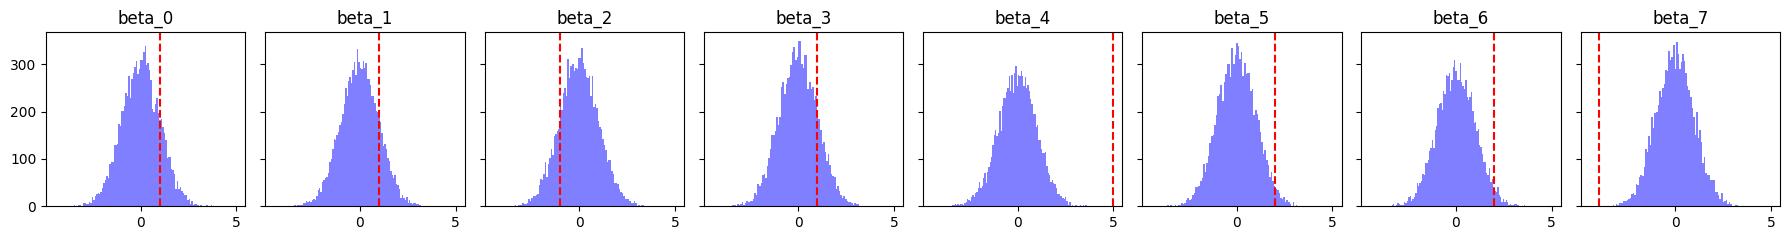

In [ ]:
# only meaningful if the outcome model is linear 

# sample from the prior:
beta_samples = rng.multivariate_normal(
    prior_mean, cov=sigma_prior * np.eye(len(prior_mean)), size=10000
)
# plot the prior samples and true_params as red crosses:
# let's do d subplots
ax, fig = plt.subplots(1, d, figsize=(18, 2.5), sharex=True, sharey=True)

# on each subplot, plot the prior samples and the true params
for i in range(d):
    fig[i].hist(beta_samples[:, i], bins=100, alpha=0.5, color="blue")
    fig[i].axvline(true_params[i], color="red", linestyle="--")
    fig[i].set_title(f"beta_{i}")

plt.tight_layout()
plt.show()

In [ ]:
n_seeds = 50
data_parameters = {
    "fixed_n_complementary": fixed_n_complementary,
    "varying_sample_sizes": varying_sample_sizes,
    "n_rct_before_split": n_rct_before_split,
    "x_distributions": x_distributions,
    "p_assigned_to_cand2": p_assigned_to_cand2,
    "p_assigned_to_host": p_assigned_to_host,
    "n_host": n_host,
    "power_x": power_x,
    "power_x_t": power_x_t,
    "outcome_function": outcome_function,
    "std_true_y": std_true_y,
    "causal_param_first_index": causal_param_first_index,
}

### 2. EIG closed form 

In [ ]:
# exact_data = generate_exact_data_varying_sample_size(
#     data_parameters, include_intercept=bool(include_intercept)
# )
# dict_additional_plots_obs_closed_from, dict_additional_plots_caus_closed_from = (
#     linear_eig_closed_form_varying_sample_size(
#         exact_data,
#         data_parameters,
#         prior_hyperparameters,
#     )
# )

In [ ]:
EIG_obs_closed_form_across_seeds, EIG_caus_closed_form_across_seeds = [], []
store_non_exact_data = {}

for i in range(n_seeds):
    nonexact_data = generate_data_varying_sample_size(
        data_parameters, include_intercept=bool(include_intercept), seed=i)
    EIGs = linear_eig_closed_form_varying_sample_size(  # CHECK what this does
        nonexact_data,
        data_parameters,
        prior_hyperparameters,
        verbose=False,
    )
    EIG_obs_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )
    store_non_exact_data[i] = nonexact_data


EIG_obs_closed_form_across_seeds = np.vstack(EIG_obs_closed_form_across_seeds)  
EIG_caus_closed_form_across_seeds = np.vstack(EIG_caus_closed_form_across_seeds)


In [ ]:
def turn_into_diff(arr):
    n, d = np.shape(arr)[0], np.shape(arr)[1]
    result = np.zeros((n//2, d))
    for i in range (n//2):
        result[i,:]=arr[2*i,:]-arr[(2*i) +1,:]
    return result

proportions = np.array(varying_sample_sizes)/fixed_n_complementary
proportions

array([1. , 1.2, 1.4, 1.6, 1.8, 2. ])

In [ ]:
predictive_cf = turn_into_diff(EIG_obs_closed_form_across_seeds)
pd.DataFrame(predictive_cf).head()

,0,1,2,3,4,5
0,0.480590,-0.002369,-0.275599,-0.686806,-0.407839,-0.965955
1,0.431526,0.206154,-0.276965,-0.633847,-0.789759,-0.997113
2,0.400044,0.267254,-0.265864,-0.400214,-0.840879,-0.830834
3,0.349631,0.044706,-0.239513,-0.400635,-0.572766,-0.992116
4,0.801665,0.347600,-0.319515,-0.398510,-0.608177,-0.989570


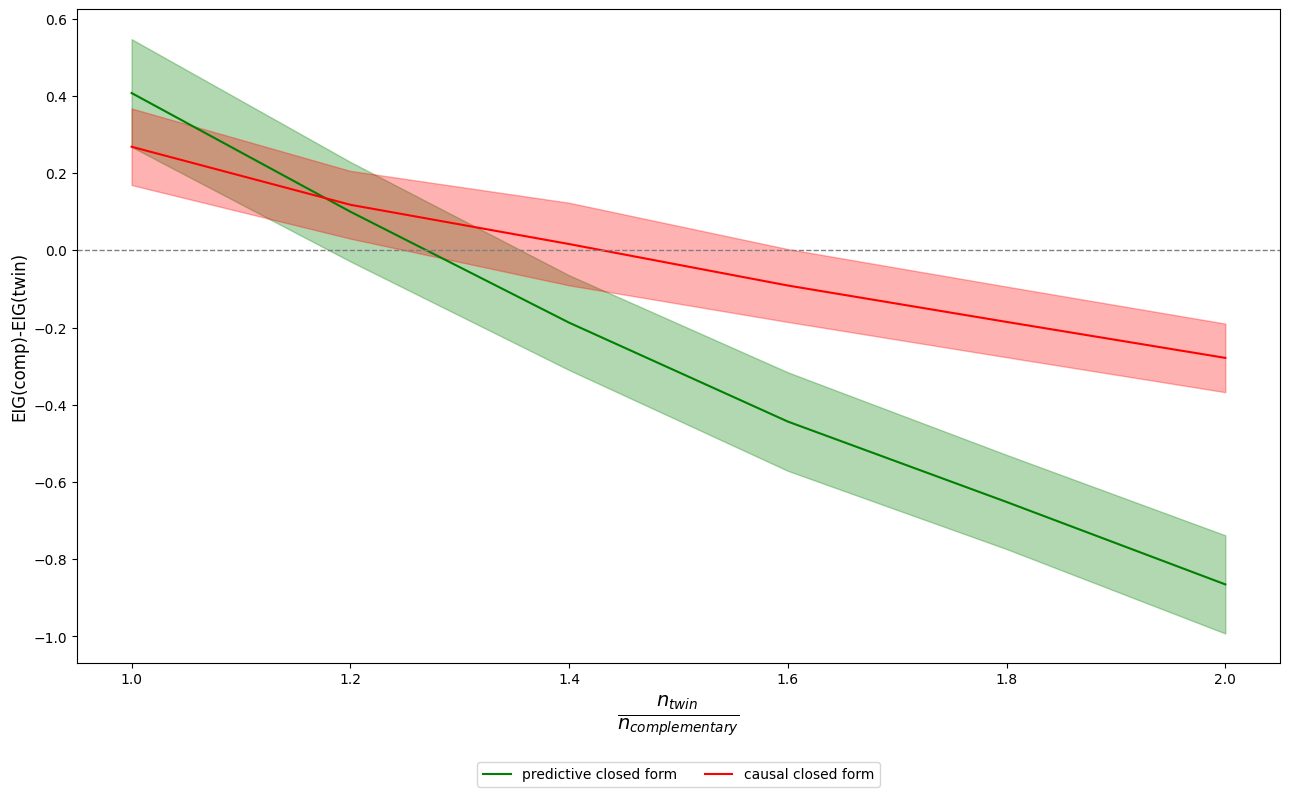

In [ ]:
dict_diff_EIG_closed_form_across_seeds = {'predictive closed form': turn_into_diff(EIG_obs_closed_form_across_seeds),\
                                         'causal closed form':turn_into_diff(EIG_caus_closed_form_across_seeds)}


color_dict = {'predictive closed form': 'green', 'causal closed form': 'red'}

plot_dict(
    x = proportions,
    dict = dict_diff_EIG_closed_form_across_seeds,
    axis_names=[r'$\frac{n_{twin}}{n_{complementary}}$', 'EIG(comp)-EIG(twin)', "Mean MSE difference"],
    dict_additional_plots=None,
    title= None,
    color_dict=color_dict,
    save=None
)


### 2. EIG from samples for varying sample sizes

In [ ]:
n_samples_outer_expectation_obs = 400
n_samples_inner_expectation_obs = 800
n_samples_outer_expectation_caus = 400
n_samples_inner_expectation_caus = 800

sampling_parameters = {
    "n_samples_inner_expectation_obs": n_samples_inner_expectation_obs,
    "n_samples_outer_expectation_obs": n_samples_outer_expectation_obs,
    "n_samples_inner_expectation_caus": n_samples_inner_expectation_caus,
    "n_samples_outer_expectation_caus": n_samples_outer_expectation_caus,
}

In [ ]:
# dict_additional_plots_obs_from_samples, dict_additional_plots_caus_from_samples = (
#     linear_eig_from_samples_varying_sample_size(
#         exact_data,
#         data_parameters,
#         prior_hyperparameters,
#         sampling_parameters
#     )
# )

# EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []


# EIG_obs_samples_across_seeds = np.vstack(EIG_obs_samples_across_seeds)  
# EIG_caus_samples_across_seeds = np.vstack(EIG_caus_samples_across_seeds)

In [ ]:
# EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []

# for i in range(n_seeds):
#     EIGs = linear_eig_from_samples_varying_sample_size(
#         store_non_exact_data[i], data_parameters, prior_hyperparameters, sampling_parameters
#     )
#     EIG_obs_samples_across_seeds.append(
#         [cand_values for cand_values in EIGs[0].values()]
#     )
#     EIG_caus_samples_across_seeds.append(
#         [cand_values for cand_values in EIGs[1].values()]
#     )

# EIG_obs_samples_across_seeds = np.vstack(EIG_obs_samples_across_seeds)  
# EIG_caus_samples_across_seeds = np.vstack(EIG_caus_samples_across_seeds)


In [ ]:

# diff_EIG_obs_samples_across_seeds = {'complementary - twin': turn_into_diff(EIG_obs_samples_across_seeds)}
# diff_EIG_caus_samples_across_seeds = {'complementary - twin': turn_into_diff(EIG_caus_samples_across_seeds)}

# plot_dict(
#     x = varying_sample_sizes,
#     dict = diff_EIG_obs_samples_across_seeds,
#     axis_names=["Sample size of candidate datasets", "EIG obs closed form"],
#     dict_additional_plots=None,
#     text=None,
#     title= "EIG obs from samples"
# )

# plot_dict(
#     x = varying_sample_sizes,
#     dict = diff_EIG_caus_samples_across_seeds,
#     axis_names=["Sample size of candidate datasets", "EIG obs closed form"],
#     dict_additional_plots=None,
#     text=None,
#     title= "EIG caus from samples"
# )

# dict_all_diff = {'predictive mcmc': turn_into_diff(EIG_obs_samples_across_seeds), 'causal mcmc': turn_into_diff(EIG_caus_samples_across_seeds), \
#                  'predictive closed form': turn_into_diff(EIG_obs_closed_form_across_seeds), 'causal closed form': turn_into_diff(EIG_caus_closed_form_across_seeds)}


In [ ]:
from scipy.interpolate import interp1d

def plot_dict(
    x,
    dict: dict,
    axis_names: list,
    mean_color_dict: dict = None,
    std_color_dict: dict = None,
    dict_additional_plots: Union [dict, None] = None,
    text: Union [str, None] = None,
    title: Union[str, None] = None,
    save: Union[str, None] = None,
    second_axis: Union[dict, None] = None,
):

    fig, ax1 = plt.subplots(figsize=(13, 10))

    for label, arr in dict.items():
        mean_data = np.mean(arr, axis=0)
        std_data = np.std(arr, axis=0)

        interp_mean_func = interp1d(x, mean_data, kind='linear')
        interp_std_func = interp1d(x, std_data, kind='linear')
        x_interp = np.linspace(min(x), max(x), num=len(mean_data)*3)  # Fine-grained x values for interpolation
        smooth_mean_data = interp_mean_func(x_interp)
        smooth_std_data = interp_std_func(x_interp)
        
        mean_color = mean_color_dict[label] if mean_color_dict is not None else "blue"
        std_color = std_color_dict[label] if std_color_dict is not None else "blue"

        ax1.plot(x_interp, smooth_mean_data, label=label, color=mean_color, linewidth=2.0)
        ax1.fill_between(
            x_interp, 
            smooth_mean_data - smooth_std_data, 
            smooth_mean_data + smooth_std_data, 
            color=std_color, alpha=0.25
            )
    if dict_additional_plots is not None:
        for key, arr in dict_additional_plots.items():
            ax1.plot(x, arr, label=key, linewidth=2.0)

    ax1.set_ylabel(axis_names[1], fontsize=23)
    ax1.set_xlabel(axis_names[0], fontsize=33)
    ax1.tick_params(axis='y', labelsize=18)
    ax1.tick_params(axis='x', labelsize=18)
    ax1.yaxis.set_label_coords(-0.085, 0.5)
    ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=len(dict.keys())//2, fontsize=20)

    if second_axis:
        ax2 = ax1.twinx() 
        for label, arr in second_axis.items():
            ax2.plot(x, arr, label=label)
        ax2.set_ylabel(axis_names[2], fontsize=21, rotation=270, labelpad=15)
        ax2.tick_params(axis='y', labelsize=18)
        ax2.legend(loc='lower left', bbox_to_anchor=(0.10, 0.17), fontsize=20)
        ax2.yaxis.set_label_coords(1.13, 0.5)


    if title is not None:
        fig.suptitle(title)

    if text is not None:
        fig.text(
            0.5, -0.2, text, ha="center", va="center", transform=plt.gca().transAxes
        )

    
    ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1)

    fig.tight_layout()
    fig.gca().set_facecolor('#F5F5F5')

    if save:
        current_time = datetime.now().strftime("%H:%M:%S")
        current_date = datetime.now().strftime("%Y-%m-%d")
        filename = f"{save}_{current_date}_{current_time}.pdf"
        plt.savefig(filename, dpi=600)

    plt.show()

NameError: name 'Union' is not defined

In [ ]:
predictive_mcmc = pd.read_csv("/Users/lucile/causal_info_gain/data_for_plots/linear_synthetic/diff_comp_twin/obs_samples.csv")
predictive_closed_form = pd.read_csv("/Users/lucile/causal_info_gain/data_for_plots/linear_synthetic/diff_comp_twin/obs_closed_form.csv")
caus_mcmc = pd.read_csv("/Users/lucile/causal_info_gain/data_for_plots/linear_synthetic/diff_comp_twin/caus_samples.csv")
caus_closed_form = pd.read_csv("/Users/lucile/causal_info_gain/data_for_plots/linear_synthetic/diff_comp_twin/caus_closed_form.csv")

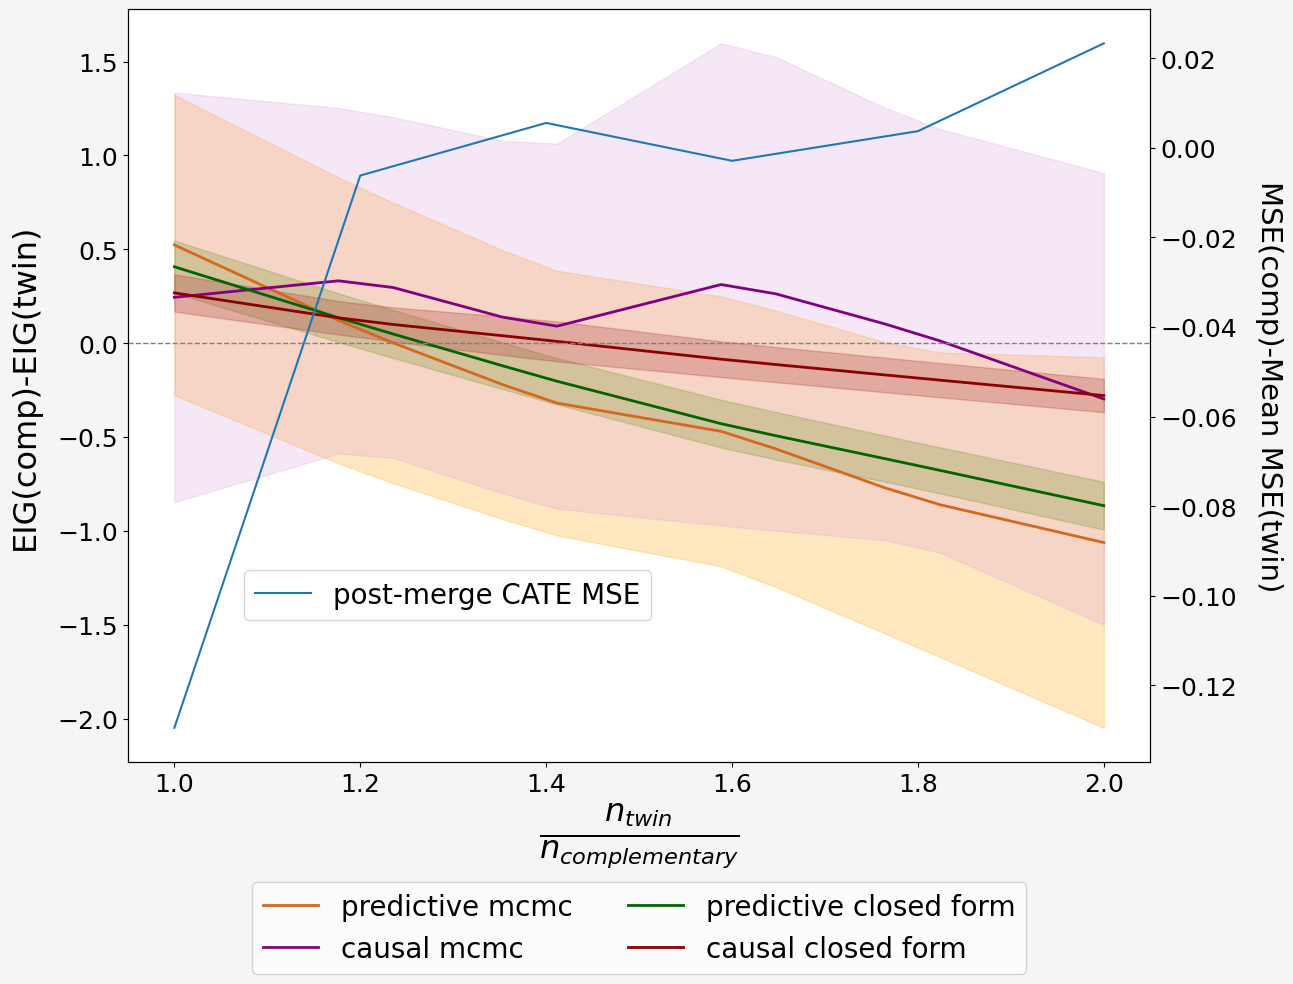

In [ ]:
dict_all_diff = {'predictive mcmc': predictive_mcmc, 'causal mcmc': caus_mcmc, \
                 'predictive closed form': predictive_closed_form, 'causal closed form': caus_closed_form}
std_color_dict = {'predictive mcmc': 'orange', 'causal mcmc': 'plum', \
                 'predictive closed form': 'olivedrab', 'causal closed form': 'brown'}
mean_color_dict = {'predictive mcmc': 'chocolate', 'causal mcmc': 'purple', \
                 'predictive closed form': 'darkgreen', 'causal closed form': 'darkred'}

plot_dict(
    x = proportions,
    dict = dict_all_diff,
    mean_color_dict= mean_color_dict,
    std_color_dict = std_color_dict,
    axis_names=[r'$\frac{n_{twin}}{n_{complementary}}$', 'EIG(comp)-EIG(twin)', 'MSE(comp)-Mean MSE(twin)'],
    dict_additional_plots=None,
    text=None,
    title= None,
    second_axis={'post-merge CATE MSE':mean_mse['CATE']},
    save = None #"/Users/lucile/causal_info_gain/plots/linear_synthetic/without_text_box"
)

### Ground truth : merging and fit Y

In [ ]:
merged_datasets = {i:{} for i in range (len(store_non_exact_data.keys()))}
CATE_function = lambda X: outcome_function(X,np.ones(len(X)), 0 )-outcome_function(X,np.zeros(len(X)),0)

for seed, seed_data_dict in store_non_exact_data.items():
    for sample_size, data_dict in seed_data_dict.items():
        merged_data_dict={}
        for name, data in data_dict.items():
            if name != 'host':
                merged_data_dict[name]= pd.concat([data_dict['host'], data_dict[name]], axis=0)
        merged_datasets[seed][sample_size] = merged_data_dict

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


merged_mse = {sample_size:{'complementary':[], 'cand2':[],'complementary_CATE':[], 'cand2_CATE':[]} for sample_size in varying_sample_sizes}

for seed, seed_data_dict in merged_datasets.items():
    for sample_size, data_dict in seed_data_dict.items():  
        for cand_name, data in data_dict.items():

            host= store_non_exact_data[seed][sample_size]['host']
            XandT_host, Y_host = host.drop(columns=['Y']), host['Y']

            X, Y = data.drop(columns=['Y']), data['Y']
            model = LinearRegression()
            model.fit(X,Y)

            Y_pred = model.predict(X)
            mse = mean_squared_error(Y, Y_pred)
            merged_mse[sample_size][cand_name].append(mse)
            true_cate = CATE_function(X)
            
            X_zero = XandT_host.copy()
            X_zero.iloc[:,4:] = 0
            X_one = XandT_host.copy()
            X_one.iloc[:,4:] = XandT_host.iloc[:,:4]

            pred_cate = model.predict(X_one) - model.predict(X_zero)
            mse_CATE = mean_squared_error(true_cate, pred_cate)
            merged_mse[sample_size][cand_name+"_CATE"].append(mse_CATE)


mean_mse = {"pred":[],"CATE":[]}

for seed, seed_data_dict in merged_mse.items():
    mse_array = pd.DataFrame.from_dict(seed_data_dict).values
    mse_array_pred = mse_array[:,0] - mse_array[:,1] # complementary - twin <0: Error(twin) > Error(complementary) for n_twin > n_complementary
    mse_array_CATE = mse_array[:,2] - mse_array[:,3] # complementary - twin <0: Error(twin) > Error(complementary) for n_twin > n_complementary
    mean_mse['pred'].append(np.mean(mse_array_pred))
    mean_mse['CATE'].append(np.mean(mse_array_CATE))

print(mean_mse)

{'pred': [0.04083431507665557, -0.01202087773477396, -0.01635784770078793, 0.018176024000070977, -0.010591321803854144, 0.002411477913180602], 'CATE': [-0.12946349166852175, -0.00618147855679677, 0.005561090445373975, -0.002895510214500838, 0.003722386687511792, 0.023324765225827028]}
